In [1]:
%matplotlib widget
import os
import brainweb
from brainweb import volshow
import numpy as np
from os import path
from tqdm.auto import tqdm
import logging
logging.basicConfig(level=logging.INFO)
import nibabel as nib
import sirf.STIR as pet
import matplotlib.pyplot as plt
import os
import sirf.Reg as reg
from math import cos, sin, pi, radians
from sirf.Utilities import examples_data_path
import shutil
import os
import sys
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import brainweb
import sirf.STIR as stir
import brainweb
import os
import numpy as np
import sirf.STIR as stir
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import sirf.STIR as stir
import sirf.Reg as reg
import numpy as np
import os
import sys
msg_red = stir.MessageRedirector('info.txt', 'warnings.txt')
dir_path = os.path.dirname(os.getcwd())
source_path = os.path.join(dir_path, 'source')
sys.path.append(source_path)

from reconstruction.reconstruction import *
from reconstruction.registration import *
from reconstruction.osem import *
from plotting_functions import plot_2d_image

# and some additional functions for plotting
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import imageio
from plotting_functions import *
from IPython.display import Image
import torch
import os
import sys


In [2]:
def crop_and_fill(templ_im, vol): 
    """Crop volumetric image data and replace image content in template image object"""
    # Get size of template image and crop
    idim_orig = templ_im.as_array().shape
    idim = (1,)*(3-len(idim_orig)) + idim_orig
    offset = (np.array(vol.shape) - np.array(idim)) // 2
    vol = vol[offset[0]:offset[0]+idim[0], offset[1]:offset[1]+idim[1], offset[2]:offset[2]+idim[2]]
    # Make a copy of the template to ensure we do not overwrite it
    templ_im_out = templ_im.copy()
    
    # Fill image content 
    templ_im_out.fill(np.reshape(vol, idim_orig))
    return(templ_im_out)

In [3]:
from sirf.Utilities import examples_data_path
data_path = examples_data_path('PET')
mmR_data_path = os.path.join(data_path, 'mMR')
print(mmR_data_path)
acq_data_small = stir.AcquisitionData(os.path.join(mmR_data_path, 'mMR_template_span11_small.hs'))
acq_data_single_slice = stir.AcquisitionData(os.path.join(mmR_data_path, 'mMR_template_single_slice.hs'))
asm_norm = stir.AcquisitionSensitivityModel(os.path.join(mmR_data_path, 'norm.n.hdr'))
asm_norm.set_up(acq_data_small)
det_efficiencies_small=acq_data_small.get_uniform_copy(1)
asm_norm.unnormalise(det_efficiencies_small)
det_efficiencies_2D = det_efficiencies_small.rebin(3)
print(det_efficiencies_2D.shape)
selected_slice = det_efficiencies_2D.shape[1] // 2
det_efficiencies_single_slice_arr = np.expand_dims(det_efficiencies_2D.as_array()[:, selected_slice, :, :], axis=0)
det_efficiencies_single_slice = acq_data_single_slice.copy()
det_efficiencies_single_slice.fill(det_efficiencies_single_slice_arr)
print(det_efficiencies_single_slice.shape)

/home/sirfuser/devel/install/share/SIRF-3.5/data/examples/PET/mMR
Reading manufacturer PET normalisation file from /home/sirfuser/devel/install/share/SIRF-3.5/data/examples/PET/mMR/norm.n.hdr
(1, 127, 126, 344)
(1, 1, 126, 344)trying GEHDF5...
not a GE HDF5 file




ERROR: ProjDataFromStream: error reading data


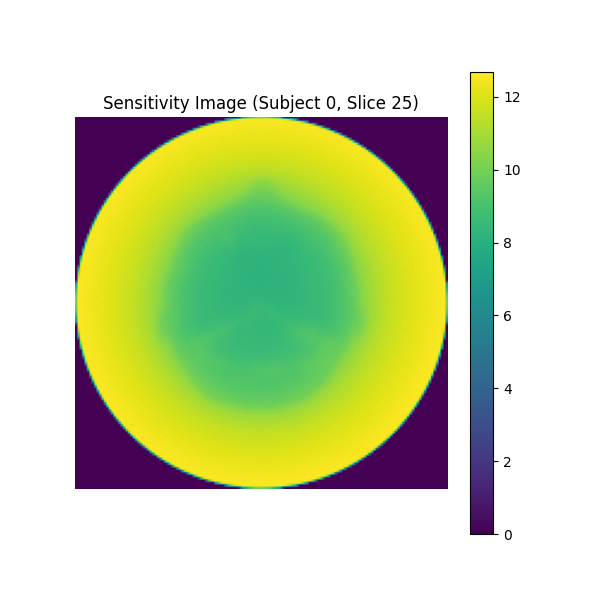

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import brainweb
import sirf.STIR as stir

# Set random seed
brainweb.seed(1337)

# Paths
dir_path = os.path.dirname(os.getcwd())
data_path = os.path.join(dir_path, 'data', 'template_data')
template_sino_path = os.path.join(data_path, 'template_sinogram.hs')

# Load template sinogram
template_sinogram = stir.AcquisitionData(template_sino_path)

# Get first BrainWeb subject
fname, url = sorted(brainweb.utils.LINKS.items())[0]
brainweb.get_file(fname, url, ".")
vol = brainweb.get_mmr_fromfile(fname, petNoise=1, t1Noise=0.75, t2Noise=0.75,
                                petSigma=1, t1Sigma=1, t2Sigma=1)

fdg_arr = vol['PET']
uMap_arr = vol['uMap']

# Choose a good slice
z_dim = fdg_arr.shape[0]
start = int(z_dim * 0.2)
end = int(z_dim * 0.8)
candidate_indices = np.linspace(start, end, 10).astype(int)

slice_idx = None
for idx in candidate_indices:
    fdg_slice = fdg_arr[idx]
    umap_slice = uMap_arr[idx]
    if np.std(umap_slice) >= 1e-4 and np.max(umap_slice) >= 0.01 and \
       np.std(fdg_slice) >= 1e-4 and np.max(fdg_slice) >= 0.01:
        slice_idx = idx
        break

if slice_idx is None:
    raise RuntimeError("No suitable slice found.")

# Crop and reshape
idim = 155
offset = (np.array(fdg_arr[slice_idx].shape) - idim) // 2
fdg_slice = fdg_arr[slice_idx, offset[0]:offset[0]+idim, offset[1]:offset[1]+idim][np.newaxis, ...]
uMap_slice = uMap_arr[slice_idx, offset[0]:offset[0]+idim, offset[1]:offset[1]+idim][np.newaxis, ...]

# Initialize SIRF image
im = template_sinogram.create_uniform_image(0)
im.initialise((1, idim, idim), (2.25, 2.09, 2.09))

# Fill slices
def crop_and_fill(image, slice_2d):
    new_img = image.get_uniform_copy(0)
    new_img.fill(slice_2d)
    return new_img

emission_image = crop_and_fill(im, fdg_slice)
attenuation_image = crop_and_fill(im, uMap_slice)

# Compute sensitivity image
acq_model = stir.AcquisitionModelUsingRayTracingMatrix()
acq_model.set_num_tangential_LORs(10)
sensitivity_model = stir.AcquisitionSensitivityModel(attenuation_image, acq_model)
acq_model.set_acquisition_sensitivity(sensitivity_model)
acq_model.set_up(template_sinogram, emission_image)

uniform_acq_data = template_sinogram.get_uniform_copy(1.0)
sensitivity_image = acq_model.backward(uniform_acq_data)

# Plot
sensitivity_np = sensitivity_image.as_array()[0]
plt.figure(figsize=(6, 6))
plt.imshow(sensitivity_np, cmap='viridis')
plt.title(f"Sensitivity Image (Subject 0, Slice {slice_idx})")
plt.axis('off')
plt.colorbar()
plt.show()


In [12]:
# Create simulated data from brainweb for testing

import os
import numpy as np
from tqdm import tqdm
import brainweb
import sirf.STIR as stir

# Set random seed
brainweb.seed(1337)

# Paths
dir_path = os.path.dirname(os.getcwd())
data_path = os.path.join(dir_path, 'data', 'template_data')
output_dir = os.path.join(dir_path, 'data', 'test_data')
os.makedirs(output_dir, exist_ok=True)

# Load template sinogram once
template_sino_path = os.path.join(data_path, 'template_sinogram.hs')
template_sinogram = stir.AcquisitionData(template_sino_path)

# Get all BrainWeb filenames
all_files = sorted(brainweb.utils.LINKS.items())

# Loop over all subjects
for subj_idx, (fname, url) in enumerate(tqdm(all_files, desc="Processing BrainWeb subjects")):
    brainweb.get_file(fname, url, ".")
    vol = brainweb.get_mmr_fromfile(fname, petNoise=1, t1Noise=0.75, t2Noise=0.75,
                                    petSigma=1, t1Sigma=1, t2Sigma=1)

    fdg_arr = vol['PET']
    uMap_arr = vol['uMap']

    z_dim = fdg_arr.shape[0]
    start = int(z_dim * 0.2)  
    end = int(z_dim * 0.8)    
    all_candidate_indices = np.linspace(start, end, 10).astype(int)

    
    slice_indices = []
    for idx in all_candidate_indices:
        fdg_slice = fdg_arr[idx]
        umap_slice = uMap_arr[idx]
    
        # Skip slices with nearly empty uMap or FDG 
        if np.std(umap_slice) < 1e-4 or np.max(umap_slice) < 0.01:
            continue
        if np.std(fdg_slice) < 1e-4 or np.max(fdg_slice) < 0.01:
            continue
    
        slice_indices.append(idx)
        if len(slice_indices) == 5:
            break

        if len(slice_indices) < 5:
            print(f"Subject {subj_idx}: Only found {len(slice_indices)} good slices — skipping.")
            continue  # skip subject with too few valid slices


    print(f"Subject {subj_idx} slice indices: {slice_indices}")


    for slice_num, slice_idx in enumerate(slice_indices, start=1):
        # Extract 2D slices
        fdg_slice = fdg_arr[slice_idx, :, :]
        uMap_slice = uMap_arr[slice_idx, :, :]

        idim = 155
        offset = (np.array(fdg_slice.shape) - idim) // 2
        fdg_slice = fdg_slice[offset[0]:offset[0]+idim, offset[1]:offset[1]+idim]
        uMap_slice = uMap_slice[offset[0]:offset[0]+idim, offset[1]:offset[1]+idim]

        # Add a channel dimension
        fdg_slice = fdg_slice[np.newaxis, ...]
        uMap_slice = uMap_slice[np.newaxis, ...]

        # Create and initialize image
        im = template_sinogram.create_uniform_image(0)
        im.initialise((1, idim, idim), (2.25, 2.09, 2.09))

        # Fill slices into SIRF image
        emission_image = crop_and_fill(im, fdg_slice)
        attenuation_image = crop_and_fill(im, uMap_slice)

        # Set up acquisition and sensitivity models
        acq_model = stir.AcquisitionModelUsingRayTracingMatrix()
        acq_model.set_num_tangential_LORs(10)
        geom_model = stir.AcquisitionModelUsingRayTracingMatrix()
        sensitivity_model = stir.AcquisitionSensitivityModel(attenuation_image, geom_model)
        acq_model.set_acquisition_sensitivity(sensitivity_model)
        acq_model.set_up(template_sinogram, emission_image)

        # Compute sensitivity image
        uniform_image = emission_image.get_uniform_copy(1.0)
        uniform_acq_data = template_sinogram.get_uniform_copy(1.0)
        sensitivity_image = acq_model.backward(uniform_acq_data)

        # Save output with sunject number and slice number
        sens_path = os.path.join(output_dir, f"sens_{subj_idx}_{slice_num}.hv")
        attn_path = os.path.join(output_dir, f"attn_{subj_idx}_{slice_num}.hv")
        emission_path = os.path.join(output_dir, f"emission_{subj_idx}_{slice_num}.hv")
        sensitivity_image.write(sens_path)
        attenuation_image.write(attn_path)
        emission_image.write(emission_path)


Processing BrainWeb subjects:   0%|                      | 0/20 [00:00<?, ?it/s]

subject_04.bin.gz: 0.00B [00:00, ?B/s]

Subject 0: Only found 1 good slices — skipping.
Subject 0: Only found 2 good slices — skipping.
Subject 0: Only found 3 good slices — skipping.
Subject 0: Only found 4 good slices — skipping.
Subject 0 slice indices: [25, 33, 41, 50, 58]
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unn

Processing BrainWeb subjects:   5%|▋             | 1/20 [00:16<05:14, 16.57s/it]

subject_05.bin.gz: 0.00B [00:00, ?B/s]

Subject 1: Only found 1 good slices — skipping.
Subject 1: Only found 2 good slices — skipping.
Subject 1: Only found 3 good slices — skipping.
Subject 1: Only found 4 good slices — skipping.
Subject 1 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  10%|█▍            | 2/20 [00:31<04:44, 15.81s/it]

subject_06.bin.gz: 0.00B [00:00, ?B/s]

Subject 2: Only found 1 good slices — skipping.
Subject 2: Only found 2 good slices — skipping.
Subject 2: Only found 3 good slices — skipping.
Subject 2: Only found 4 good slices — skipping.
Subject 2 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  15%|██            | 3/20 [00:44<04:08, 14.59s/it]

subject_18.bin.gz: 0.00B [00:00, ?B/s]

Subject 3: Only found 1 good slices — skipping.
Subject 3: Only found 2 good slices — skipping.
Subject 3: Only found 3 good slices — skipping.
Subject 3: Only found 4 good slices — skipping.
Subject 3 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  20%|██▊           | 4/20 [01:06<04:40, 17.52s/it]

subject_20.bin.gz: 0.00B [00:00, ?B/s]

Subject 4: Only found 1 good slices — skipping.
Subject 4: Only found 2 good slices — skipping.
Subject 4: Only found 3 good slices — skipping.
Subject 4: Only found 4 good slices — skipping.
Subject 4 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  25%|███▌          | 5/20 [01:30<04:56, 19.76s/it]

subject_38.bin.gz: 0.00B [00:00, ?B/s]

Subject 5: Only found 1 good slices — skipping.
Subject 5: Only found 2 good slices — skipping.
Subject 5: Only found 3 good slices — skipping.
Subject 5: Only found 4 good slices — skipping.
Subject 5 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  30%|████▏         | 6/20 [01:46<04:15, 18.26s/it]

subject_41.bin.gz: 0.00B [00:00, ?B/s]

Subject 6: Only found 1 good slices — skipping.
Subject 6: Only found 2 good slices — skipping.
Subject 6: Only found 3 good slices — skipping.
Subject 6: Only found 4 good slices — skipping.
Subject 6 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  35%|████▉         | 7/20 [01:59<03:37, 16.74s/it]

subject_42.bin.gz: 0.00B [00:00, ?B/s]

Subject 7: Only found 1 good slices — skipping.
Subject 7: Only found 2 good slices — skipping.
Subject 7: Only found 3 good slices — skipping.
Subject 7: Only found 4 good slices — skipping.
Subject 7 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  40%|█████▌        | 8/20 [02:13<03:10, 15.89s/it]

subject_43.bin.gz: 0.00B [00:00, ?B/s]

Subject 8: Only found 1 good slices — skipping.
Subject 8: Only found 2 good slices — skipping.
Subject 8: Only found 3 good slices — skipping.
Subject 8: Only found 4 good slices — skipping.
Subject 8 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  45%|██████▎       | 9/20 [02:28<02:52, 15.68s/it]

subject_44.bin.gz: 0.00B [00:00, ?B/s]

Subject 9: Only found 1 good slices — skipping.
Subject 9: Only found 2 good slices — skipping.
Subject 9: Only found 3 good slices — skipping.
Subject 9: Only found 4 good slices — skipping.
Subject 9 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  50%|██████▌      | 10/20 [02:43<02:32, 15.28s/it]

subject_45.bin.gz: 0.00B [00:00, ?B/s]

Subject 10: Only found 1 good slices — skipping.
Subject 10: Only found 2 good slices — skipping.
Subject 10: Only found 3 good slices — skipping.
Subject 10: Only found 4 good slices — skipping.
Subject 10 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  55%|███████▏     | 11/20 [02:56<02:12, 14.75s/it]

subject_46.bin.gz: 0.00B [00:00, ?B/s]

Subject 11: Only found 1 good slices — skipping.
Subject 11: Only found 2 good slices — skipping.
Subject 11: Only found 3 good slices — skipping.
Subject 11: Only found 4 good slices — skipping.
Subject 11 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  60%|███████▊     | 12/20 [03:11<01:56, 14.58s/it]

subject_47.bin.gz: 0.00B [00:00, ?B/s]

Subject 12: Only found 1 good slices — skipping.
Subject 12: Only found 2 good slices — skipping.
Subject 12: Only found 3 good slices — skipping.
Subject 12: Only found 4 good slices — skipping.
Subject 12 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  65%|████████▍    | 13/20 [03:26<01:43, 14.76s/it]

subject_48.bin.gz: 0.00B [00:00, ?B/s]

Subject 13: Only found 1 good slices — skipping.
Subject 13: Only found 2 good slices — skipping.
Subject 13: Only found 3 good slices — skipping.
Subject 13: Only found 4 good slices — skipping.
Subject 13 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  70%|█████████    | 14/20 [03:41<01:29, 14.98s/it]

subject_49.bin.gz: 0.00B [00:00, ?B/s]

Subject 14: Only found 1 good slices — skipping.
Subject 14: Only found 2 good slices — skipping.
Subject 14: Only found 3 good slices — skipping.
Subject 14: Only found 4 good slices — skipping.
Subject 14 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  75%|█████████▊   | 15/20 [03:55<01:13, 14.70s/it]

subject_50.bin.gz: 0.00B [00:00, ?B/s]

Subject 15: Only found 1 good slices — skipping.
Subject 15: Only found 2 good slices — skipping.
Subject 15: Only found 3 good slices — skipping.
Subject 15: Only found 4 good slices — skipping.
Subject 15 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  80%|██████████▍  | 16/20 [04:09<00:57, 14.26s/it]

subject_51.bin.gz: 0.00B [00:00, ?B/s]

Subject 16: Only found 1 good slices — skipping.
Subject 16: Only found 2 good slices — skipping.
Subject 16: Only found 3 good slices — skipping.
Subject 16: Only found 4 good slices — skipping.
Subject 16 slice indices: [25, 33, 41, 50, 58]
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applyin

Processing BrainWeb subjects:  85%|███████████  | 17/20 [04:25<00:44, 14.95s/it]

subject_52.bin.gz: 0.00B [00:00, ?B/s]

Subject 17: Only found 1 good slices — skipping.
Subject 17: Only found 2 good slices — skipping.
Subject 17: Only found 3 good slices — skipping.
Subject 17: Only found 4 good slices — skipping.
Subject 17 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  90%|███████████▋ | 18/20 [04:39<00:29, 14.72s/it]

subject_53.bin.gz: 0.00B [00:00, ?B/s]

Subject 18: Only found 1 good slices — skipping.
Subject 18: Only found 2 good slices — skipping.
Subject 18: Only found 3 good slices — skipping.
Subject 18: Only found 4 good slices — skipping.
Subject 18 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects:  95%|████████████▎| 19/20 [04:53<00:14, 14.53s/it]

subject_54.bin.gz: 0.00B [00:00, ?B/s]

Subject 19: Only found 1 good slices — skipping.
Subject 19: Only found 2 good slices — skipping.
Subject 19: Only found 3 good slices — skipping.
Subject 19: Only found 4 good slices — skipping.
Subject 19 slice indices: [25, 33, 41, 50, 58]


Processing BrainWeb subjects: 100%|█████████████| 20/20 [05:08<00:00, 15.43s/it]


In [13]:
# Create Transformed images

import os
import numpy as np
import sirf.STIR as stir

dir_path = os.path.dirname(os.getcwd())
input_dir = os.path.join(dir_path, 'data', 'test_data')
output_dir = os.path.join(dir_path, 'data', 'test_data')
os.makedirs(output_dir, exist_ok=True)
data_path = os.path.join(dir_path, 'data', 'template_data')
template_sinogram = stir.AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))

# Setup
num_subjects = 20
num_slices = 5

# Loop over all subjects and slices
for i in range(num_subjects):
    for j in range(1, num_slices + 1):
        attn = stir.ImageData(os.path.join(input_dir, f'attn_{i}_{j}.hv'))
        emis = stir.ImageData(os.path.join(input_dir, f'emission_{i}_{j}.hv'))

        # Generate transformed emission and attenuation images
        transformed_emis, transformed_attn = generate_transformed_image(emis, attn)
        #motion_transform = find_transformation_matrix(transformed_attn, attn)
        
        acq_model = stir.AcquisitionModelUsingRayTracingMatrix()
        acq_model.set_num_tangential_LORs(10)
        geometric_transform_for_sensitivity = stir.AcquisitionModelUsingRayTracingMatrix()
        sensitivity_model = stir.AcquisitionSensitivityModel(transformed_attn, geometric_transform_for_sensitivity)
        acq_model.set_acquisition_sensitivity(sensitivity_model)
        acq_model.set_up(template_sinogram, transformed_emis)
        
        uniform_acq_data = template_sinogram.get_uniform_copy(1.0)
        transformed_sens = acq_model.backward(uniform_acq_data)
        
        # 4. Save transformed images
        transformed_emis.write(os.path.join(output_dir, f'transform_emission_{i}_{j}.hv'))
        transformed_attn.write(os.path.join(output_dir, f'transform_attn_{i}_{j}.hv'))
        transformed_sens.write(os.path.join(output_dir, f'transform_sens_{i}_{j}.hv'))
        
        print(f"Saved transformed images")


.ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok
Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
applying unnormalisation...ok
backprojecting...ok


Saved transformed images
